# Agentic RAG for EOG Energy
## By Luis Macías [](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/)

Retrieval agents are useful when you want an LLM to make a decision about whether to retrieve context from a vectorstore or respond to the user directly.

### Setup the environment

In [27]:
# Let’s download the required packages and set our API keys:
%%capture --no-stderr
%pip install -U --quiet langgraph "langchain[openai]" langchain-community langchain-text-splitters pymupdf

In [3]:
# Setup the API KEY
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:··········


## 1. Preprocess Document

### 1. Fetch documents to use in our RAG system.

#### a. URL

In [8]:
# import the loader for URLS
from langchain_community.document_loaders import WebBaseLoader

# set the URLs
urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

# load the documents  (list comprehension)
docs = [WebBaseLoader(url).load() for url in urls]

In [7]:
# example of part of the loaded document
docs[0][0].page_content.strip()[:1000]

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\

#### b. PDF's

In [28]:
# import the loader for PDFs
from langchain_community.document_loaders import PyMuPDFLoader

# create the loader with page mode and extracting tables and images
loader = PyMuPDFLoader(
    file_path = "2024-Annual-Report-Web-Ready.pdf",
    # headers = None
    # password = None,
    mode = "page",
    #pages_delimiter = "",
    extract_images = True,
    # images_parser = TesseractBlobParser(),
    images_inner_format = "markdown-img",
    extract_tables = "csv",
    # extract_tables_settings = None,
)

# lazy load the document
docs = []
docs_lazy = loader.lazy_load()

for doc in docs_lazy:
    docs.append(doc)


In [30]:
# example of part of the loaded document with its metadata
print(docs[10].page_content[:100])
print(docs[10].metadata)

Looking Forward
EOG has never been better positioned to deliver 
long-term shareholder value. The de
{'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 20.0 (Windows)', 'creationdate': '2025-03-25T11:50:26-04:00', 'source': '2024-Annual-Report-Web-Ready.pdf', 'file_path': '2024-Annual-Report-Web-Ready.pdf', 'total_pages': 145, 'format': 'PDF 1.4', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-03-25T16:45:33-04:00', 'trapped': '', 'modDate': "D:20250325164533-04'00'", 'creationDate': "D:20250325115026-04'00'", 'page': 10}


### 2. Split the fetched documents into smaller chunks for indexing into our vectorstore:

In [32]:
# import the splitter
from langchain_text_splitters import RecursiveCharacterTextSplitter

# list of documents in a form of list comprehensions for URLs
# docs_list = [item for sublist in docs for item in sublist]
docs_list = []
for doc in docs:
  # Check if the item is a tuple and extract the first element if it is
  # PyMuPDFLoader returns a list of tuples (document,metadata)
  if isinstance(doc, tuple):
    docs_list.append(doc[0])
  else:
    docs_list.append(doc)

# split the text
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=800, chunk_overlap=200
)

# different splits of the document
doc_splits = text_splitter.split_documents(docs_list)

In [33]:
# example of content of the splitted document with metadata
print(doc_splits[100].page_content.strip())
print(doc_splits[100].metadata)

•
the impact of climate change-related legislation, policies and initiatives; climate change-related political, social and
shareholder activism; and physical, transition and reputational risks and other potential developments related to climate
change;
•
the extent to which EOG is able to successfully and economically develop, implement and carry out its emissions and
other environmental or safety-related initiatives and achieve its related targets, goals, ambitions and initiatives;
•
EOG's ability to effectively integrate acquired crude oil and natural gas properties into its operations, identify and
resolve existing and potential issues with respect to such properties and accurately estimate reserves, production,
drilling, completion and operating costs and capital expenditures with respect to such properties;
•
the extent to which EOG's third-party-operated crude oil and natural gas properties are operated successfully,
economically and in compliance with applicable laws and regulat

## 2. Create a retriever tool

Index our split documents into a vector store that we’ll use for semantic search.

### 1. Use an in-memory vector store and OpenAI embeddings:

In [34]:
# imports necesary for the VectoStore and Embeddings (OpenAI)
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

# create the Vectorstore with the splits of the document
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=OpenAIEmbeddings()
)

# create the retriever from that VectorStore
retriever = vectorstore.as_retriever()

### 2. Create a retriever tool using LangChain’s prebuilt create_retriever_tool:

In [35]:
# Imports for the retriever tool
from langchain.tools.retriever import create_retriever_tool

# Create the retriever tool with a retriever, name, description
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_RAG",
    "Search and return information about EOG performance.",
)

### 3. Test the tool:

In [37]:
# try a query
retriever_tool.invoke({"query": "what can you say about the culture"})

"EOG’s community engagement is local. Each of our \noperating areas is unique, and we proactively engage \nwith community stakeholders, including property \nowners, civic leaders, elected officials, first responders, \nnonprofits, and local community groups, to identify and \naddress specific community needs and concerns. From \nour 2016 letter: “While we pull in one direction, we are \na decentralized organization of employees that live and \nwork in the communities where we operate.” \nCulture\nThere is not a single annual report shareholder letter \nin our history that does not highlight our number one \ncompetitive advantage – EOG’s unique culture. \nOur decentralized, non-bureaucratic organization \nplaces value creation in the field at the asset level, in \nthe hands of each of our employees. From our 1999 \nletter: “We’ll maintain the decentralized structure that \nwe’ve successfully built over the years and embrace \ntechnological change wherever it’s advantageous.” \nFrom our 

## 3. Generate query

Now we will start building components (nodes and edges) for our agentic RAG graph.

Note that the components will operate on the MessagesState — graph state that contains a messages key with a list of chat messages.

### 1. Build a `generate_query_or_respond` node. It will call an LLM to generate a response based on the current graph state (list of messages). Given the input messages, it will decide to retrieve using the retriever tool, or respond directly to the user. Note that we’re giving the chat model access to the `retriever_tool` we created earlier via .bind_tools:

In [38]:
# imports to chat with the LLM and keep messages in the state
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

# the model we're using and temp=0 to not halucitante
response_model = init_chat_model("openai:gpt-4.1", temperature=0)

# function that decides if query the RAG or direct response from LLM
def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

### 2. Try it on a random input:

In [39]:
# message not related to RAG (hello!)
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I help you today?


### 3. Ask a question that requires semantic search:

In [40]:
# query that use the RAG
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does Ezra Y. Yacob say about culture?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_RAG (call_4Z4TxbMNiLUcomfnm5esLR3Q)
 Call ID: call_4Z4TxbMNiLUcomfnm5esLR3Q
  Args:
    query: Ezra Y. Yacob views on culture


## 4. Grade documents

### 1. Add a conditional edge — `grade_documents` — to determine whether the retrieved documents are relevant to the question. We will use a model with a structured output schema GradeDocuments for document grading. Thegrade_documents function will return the name of the node to go to based on the grading decision (`generate_answer` or `rewrite_question`):

In [41]:
# Pydantic for class definition for model
from pydantic import BaseModel, Field
from typing import Literal

# to grade the prompt on a base of yes/no to relevance for the question
GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)

# class used to create objects from the documents and give them a grade
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

# this model can be different to the one used previusly, maybe a reasoning llm
grader_model = init_chat_model("openai:gpt-4.1", temperature=0)

# function to grade each document receives the state and decides if answer or
# rewrite the question
def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

2. Run this with irrelevant documents in the tool response:

In [42]:
# import to convert messages
from langchain_core.messages import convert_to_messages

#input format to check how the system grades
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Ezra Y. Yacob say about culture?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_RAG",
                        "args": {"query": "Ezra Y. Yacob views on culture"},
                    }
                ],
            },
            # irrelevant content for test
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

### 3. Confirm that the relevant documents are classified as such:

In [43]:
#input format to check how the system grades
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Ezra Y. Yacob say about culture?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_RAG",
                        "args": {"query": "Ezra Y. Yacob views on culture"},
                    }
                ],
            },
            # relevant content
            {
                "role": "tool",
                "content": """EOG’s unique culture underpins our entire value
proposition. And it is our employees, who embrace and embody our culture, that are the number one driver of
EOG’s success these past 25 years. I want to thank our employees for consistently executing EOG’s strategy
year after year.""",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'generate_answer'

## 5. Rewrite question

### 1. Build the rewrite_question node. The retriever tool can return potentially irrelevant documents, which indicates a need to improve the original user question. To do so, we will call the rewrite_question node:

In [44]:
# Prompt to rewrite the question if we receive irrelevant documents
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

# function that rewrites the original question to get better responses
def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

### 2. Try it out:

In [45]:
#input format to check how the system grades
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_RAG",
                        "args": {"query": "Ezra Y. Yacob views on culture"},
                    }
                ],
            },
            # irrelevant content for test
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

Certainly! Here’s an improved version of the question:

**"What are Ezra Y. Yacob's views or arguments regarding the concept of culture?"**


## 6. Generate an answer

### 1. Build generate_answer node: if we pass the grader checks, we can generate the final answer based on the original question and the retrieved context:

In [22]:
# prompt if the question was ok from the user
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)

# function to generate answer if the question was ok from the user
def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

### 2. Try it:

In [46]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Ezra Y. Yacob say about culture?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_RAG",
                        "args": {"query": "Ezra Y. Yacob views on culture"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": """EOG’s unique culture underpins our entire value
proposition. And it is our employees, who embrace and embody our culture, that are the number one driver of
EOG’s success these past 25 years. I want to thank our employees for consistently executing EOG’s strategy
year after year.""",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Ezra Y. Yacob says that EOG’s unique culture underpins the company’s entire value proposition. He emphasizes that employees who embrace and embody this culture are the number one driver of EOG’s success over the past 25 years. He thanks employees for consistently executing EOG’s strategy year after year.


## 7. Assemble the graph

In [47]:
# imports to assemble the graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# initiate the workflow
workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

### 2. Visualize the graph

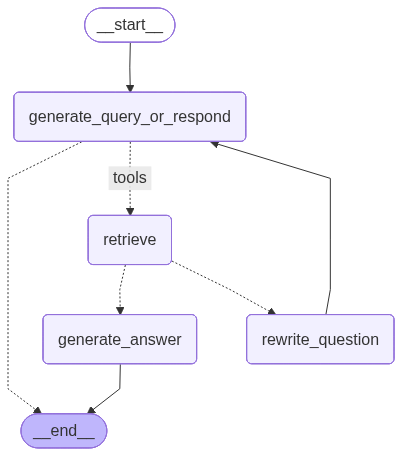

In [48]:
# import to display the graph
from IPython.display import Image, display

#display the graph as an image
display(Image(graph.get_graph().draw_mermaid_png()))

## 8. Run the agentic RAG

In [51]:
# run the Agentic graph RAG
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                #"content": "What does Ezra Y. Yacob say about culture?",
                "content": "What are the risks related to cash flow for EOG?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_RAG (call_qS8woFBtf944P1Hk8QnvSXEi)
 Call ID: call_qS8woFBtf944P1Hk8QnvSXEi
  Args:
    query: cash flow risks for EOG



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_RAG

ITEM 1A. Risk Factors
Our business and operations are subject to many risks. The risks described below may not be the only risks we face, as
our business and operations may also be subject to risks that we do not yet know of, or that we currently believe are immaterial.
If any of the events or circumstances described below actually occurs, our business, financial condition, results of operations or
cash flows could be materially and adversely affected and the trading price of our common stock could decline. The following
risk factors should be read in conjunction with the other information contain